In [58]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
df = pd.read_csv("https://www.ndbc.noaa.gov/data/realtime2/46268.txt",delim_whitespace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2180 entries, 0 to 2179
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #YY     2180 non-null   object
 1   MM      2180 non-null   object
 2   DD      2180 non-null   object
 3   hh      2180 non-null   object
 4   mm      2180 non-null   object
 5   WDIR    2180 non-null   object
 6   WSPD    2180 non-null   object
 7   GST     2180 non-null   object
 8   WVHT    2180 non-null   object
 9   DPD     2180 non-null   object
 10  APD     2180 non-null   object
 11  MWD     2180 non-null   object
 12  PRES    2180 non-null   object
 13  ATMP    2180 non-null   object
 14  WTMP    2180 non-null   object
 15  DEWP    2180 non-null   object
 16  VIS     2180 non-null   object
 17  PTDY    2180 non-null   object
 18  TIDE    2180 non-null   object
dtypes: object(19)
memory usage: 323.7+ KB


In [60]:
df.iloc[1,:]

#YY     2022
MM        06
DD        10
hh        23
mm        00
WDIR      MM
WSPD      MM
GST       MM
WVHT     0.5
DPD       13
APD      4.3
MWD      194
PRES      MM
ATMP    19.7
WTMP    20.7
DEWP      MM
VIS       MM
PTDY      MM
TIDE      MM
Name: 1, dtype: object

In [61]:
#df.iloc[1:-1,9].values
train_y = torch.tensor(df.iloc[1:-1,8].values.astype(np.float32))
train_x = torch.tensor(df.iloc[1:-1,9].values.astype(np.float32))

In [62]:
# train_y.head()
# train_x.head()
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [63]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.768   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.732   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.696   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.659   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.621   lengthscale: 0.913   noise: 0.513
Iter 6/50 - Loss: 0.583   lengthscale: 0.974   noise: 0.474
Iter 7/50 - Loss: 0.544   lengthscale: 1.037   noise: 0.437
Iter 8/50 - Loss: 0.505   lengthscale: 1.104   noise: 0.403
Iter 9/50 - Loss: 0.466   lengthscale: 1.173   noise: 0.370
Iter 10/50 - Loss: 0.426   lengthscale: 1.243   noise: 0.340
Iter 11/50 - Loss: 0.385   lengthscale: 1.315   noise: 0.312
Iter 12/50 - Loss: 0.345   lengthscale: 1.390   noise: 0.286
Iter 13/50 - Loss: 0.304   lengthscale: 1.467   noise: 0.262
Iter 14/50 - Loss: 0.263   lengthscale: 1.548   noise: 0.239
Iter 15/50 - Loss: 0.222   lengthscale: 1.627   noise: 0.218
Iter 16/50 - Loss: 0.182   lengthscale: 1.707   noise: 0.199
Iter 17/50 - Loss: 0.141   length

In [64]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

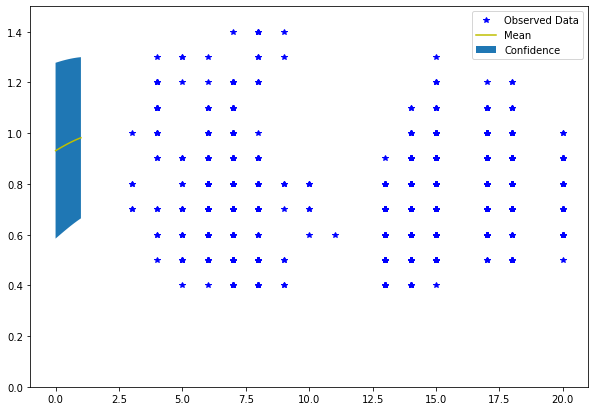

In [91]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'b*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'y')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=1)
    ax.set_ylim([0, 1.5])
    # ax.patch.set_facecolor('green')
    # ax.patch.set_alpha(.1)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])